In [100]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import csv
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from IPython.display import display

In [101]:
with open('chembl_dopamin_d2_rp_ki.csv', "r") as f:
    reader = csv.DictReader(f, delimiter=";")
    ligands = [Chem.MolFromSmiles(m["Smiles"]) for m in reader]

supplier = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in supplier if m!=None]

print(len(ligands))
print(len(drugbank))

RDKit ERROR: [19:28:19] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [19:28:19] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [19:28:19] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [19:28:19] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [19:28:19] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [19:28:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [19:28:19] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [19:28:19] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [19:28:19] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [19:28:19] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [19:28:19] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [19:28:19] Can't kek

10473
7113


RDKit ERROR: [19:28:21] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [19:28:21] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [19:28:21] ERROR: Could not sanitize molecule ending on line 1151592


Funkce pro výpočet Tanimotovy podobnosti.

In [102]:
def tanimoto_coef(x, y):
    similar = 0
    all = 0
    for bx, by in zip(x, y):
        if bx == 1 and bx == by:
            similar += 1
        if bx == 1 or by == 1:
            all += 1
    return similar/all    

Testování Tanimotovy podobnosti, použila jsem příklady z podkladů.

In [103]:
print(tanimoto_coef([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto_coef([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto_coef([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto_coef([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto_coef([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2
mol1 = MACCSkeys.GenMACCSKeys(ligands[42])
mol2 = MACCSkeys.GenMACCSKeys(ligands[6742])
print(mol1.ToBitString())
print(mol2.ToBitString())
print("Tanimoto by Áňa: " + str(tanimoto_coef(mol1, mol2)))
print("Tanimoto by RDkit " + str(DataStructs.TanimotoSimilarity(mol1, mol2)))

0.0
0.3333333333333333
0.5
0.75
1.0
00000000000000000000000000000000000000000010000000001000000000100100000000010001100101110000001010101101010100010000101011101100110001110110001011011010010110101111010
00000000000000000000000000000000110010100000000000000000000000100111000000110101011101101011001010101100110000011001101011101100110001010110001011011101010110101111010
Tanimoto by Áňa: 0.6119402985074627
Tanimoto by RDkit 0.6119402985074627


Předem se omlouvám za zmatek v tomto cvičení, dělala jsem ho po částech, na přeskáčku, ale pokusím se všude popsat moje myšlenkové pochody.

Vytvoření fingerprintů pro drugbank a d2d.

In [104]:
d2d_hfp = [Chem.GetMorganFingerprintAsBitVect(l, 2, nBits = 1024) for l in ligands]
db_hfp = [Chem.GetMorganFingerprintAsBitVect(d, 2, nBits = 1024) for d in drugbank]

Funkce, která vrací dataframe molekul datasetu a jejich podobnost s danou molekulou - fp.

In [105]:
def similarity_search_fancy(fp, dataset):
    cols = ["molecule", "smiles", "similarity"]
    res = pd.DataFrame(columns = cols)
    for i,m in enumerate(dataset):
        res.loc[i] = [m] + [Chem.MolToSmiles(m)] + [DataStructs.TanimotoSimilarity(fp, Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024))]
    PandasTools.AddMoleculeColumnToFrame(res, smilesCol="smiles")
    return res

Zkouška funkce - měření similarity levodopy s molekulami drugbank.

RDKit ERROR: [19:28:21] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [19:28:44] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [19:28:44] Explicit valence for atom # 3 N, 4, is greater than permitted


,molecule,smiles,similarity,ROMol
1110,,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,1.0,

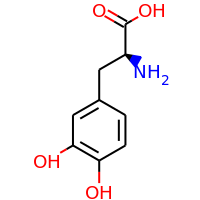
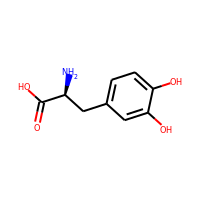

In [106]:
levodopa = Chem.MolFromSmiles("C1=CC(=C(C=C1CC(C(=O)O)N)O)O")
levodopa_fp = Chem.GetMorganFingerprintAsBitVect(levodopa, 2, nBits = 1024)
levodopa_similarities = similarity_search_fancy(levodopa_fp, drugbank)
levodopa_similarities.loc[levodopa_similarities['similarity'] > 0.8]

Jedinou látkou podobnou alespoň z 80 % levodopě je sama levodopa. Chtěla bych jich ale vidět více. Nejdřív mi ale přišlo dobré vědět, jak je vlastně podobnost rozdělená.

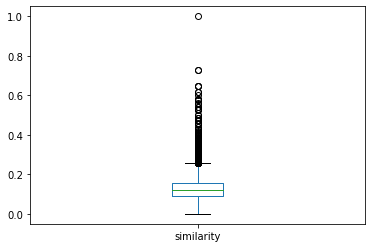

In [107]:
levodopa_similarities.boxplot(column="similarity", grid=False)

In [108]:
def get_most_similar(df, treshold):
    return df.loc[df['similarity'] > treshold]

Vizualizace molekul podobných levodopě alespoň z šedesáti procent.

,molecule,smiles,similarity,ROMol
27,,N[C@@H](Cc1ccc(O)cc1)C(=O)O,0.645161,
1110,,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,1.000000,
1530,,N[C@@H](Cc1ccc(O)c(I)c1)C(=O)O,0.727273,
2093,,N[C@@H](Cc1cccc(O)c1)C(=O)O,0.617647,
3141,,N[C@@H](Cc1cccc(O)c1)C(=O)O,0.617647,
3401,,N[C@@H](Cc1ccc(O)cc1)C(=O)O,0.645161,
3428,,N[C@@H](Cc1ccc(O)c([N+](=O)[O-])c1)C(=O)O,0.648649,
3941,,N[C@@H](Cc1ccc(O)c(F)c1)C(=O)O,0.727273,

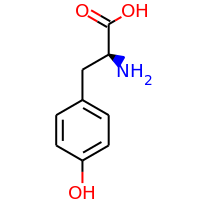
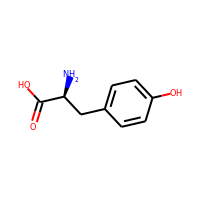
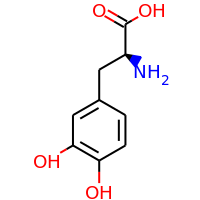
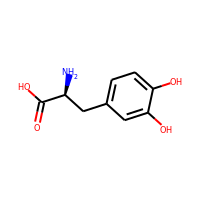
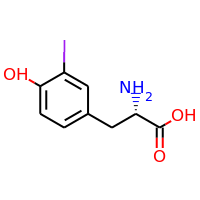
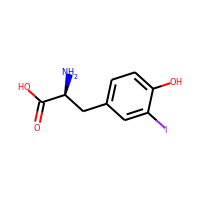
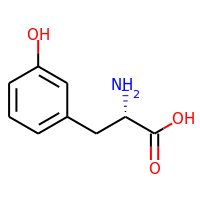
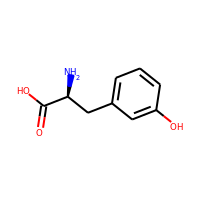
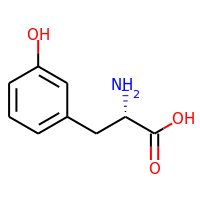
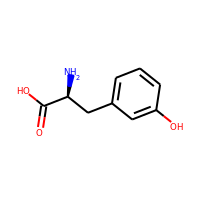
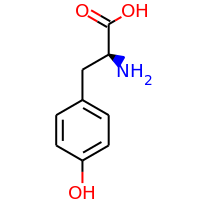
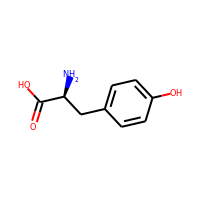
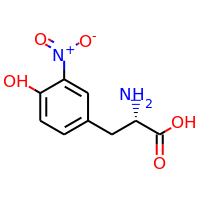
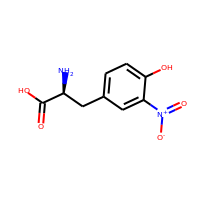
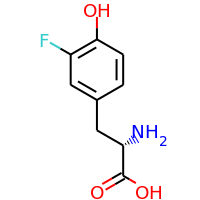
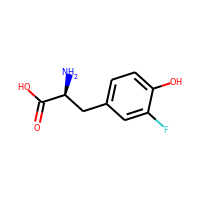

In [109]:
get_most_similar(levodopa_similarities, 0.6)

Podobná funkce jako similarity_search_fancy, ale s méně "fancy" výstupem, vrací list tuples - index molekuly a její podobnost s hledanou molekulou. Beru v potaz jen molekuly s alespoň 80% podobností, stejně jako v podkladech.

In [110]:
#all arguments already fingerprints
def similarity_search(mol, dataset, t):
    sims = []
    for i,d in enumerate(dataset):
        coef = DataStructs.TanimotoSimilarity(mol,d)
        if coef >= t:
            sims.append((i, coef))
    return sims

Hledání podobných molekul v drugbank. Přičemž takové d2d molekuly, které nemají žádný hit (žádnou podobnou molekulu v drugbank) rovnou vynechávám.

In [111]:
similarities_d2d = []
for i, d in enumerate(d2d_hfp):
    drug_similarity = similarity_search(d, db_hfp, 0.8)
    if drug_similarity != []:
        similarities_d2d.append((i,drug_similarity))
len(similarities_d2d)

1062

In [112]:
similarities_d2d

[(1, [(300, 1.0)]),
 (2, [(300, 1.0)]),
 (28, [(389, 1.0)]),
 (38, [(389, 1.0)]),
 (71, [(321, 1.0)]),
 (142, [(4444, 1.0)]),
 (177, [(223, 1.0)]),
 (178, [(136, 1.0)]),
 (179, [(389, 0.8723404255319149)]),
 (201, [(252, 1.0)]),
 (204, [(867, 1.0)]),
 (243, [(389, 1.0)]),
 (270, [(1004, 1.0), (2587, 1.0)]),
 (275, [(4626, 1.0)]),
 (277, [(1012, 1.0)]),
 (281, [(164, 1.0)]),
 (288, [(952, 1.0), (1112, 0.8064516129032258)]),
 (332, [(158, 1.0)]),
 (389, [(300, 1.0)]),
 (422, [(295, 1.0)]),
 (453, [(598, 0.8048780487804879)]),
 (531, [(598, 1.0)]),
 (550, [(1027, 1.0)]),
 (557, [(459, 1.0), (1067, 1.0)]),
 (560, [(2519, 1.0)]),
 (561, [(377, 1.0)]),
 (568, [(1018, 1.0)]),
 (590, [(389, 1.0)]),
 (592, [(1100, 1.0)]),
 (596, [(246, 1.0)]),
 (597, [(302, 1.0), (937, 0.84)]),
 (598, [(288, 1.0)]),
 (599, [(1093, 1.0)]),
 (608, [(681, 0.8095238095238095)]),
 (609, [(375, 1.0)]),
 (615, [(4148, 1.0)]),
 (620, [(743, 1.0)]),
 (624, [(1052, 1.0)]),
 (627, [(6638, 1.0)]),
 (633, [(386, 1.0)]),
 (6

Ve výsledku mne překvapilo, že molekuly s indexem 2 a 3 mají s molekulou 300 z drugbanku obě podobnost 100 %, tak jsem se tomu chtěla podívat na zoubek. A vskutku (až na stereochemii) jsou stejné. (Jedná se o pramipexol, lék na PD a RLS) To mě trochu rozhodilo a dále v notebooku jsem to ještě řešila.

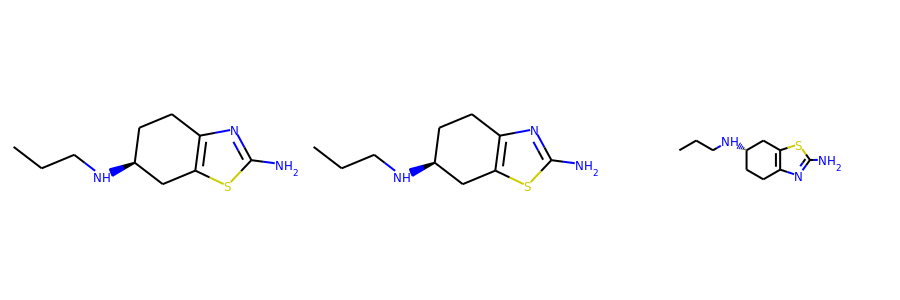

In [113]:
suspicious_molecules_index = [1, 2]
db_hit = 300
suspicious_molecules = [ligands[i] for i in suspicious_molecules_index]
suspicious_molecules.append(drugbank[300])
Draw.MolsToGridImage(suspicious_molecules, molsPerRow=3, subImgSize=(300,300))

Kolikrát byla molekula z drugbank podobná d2d ligandů.

In [114]:
print("pocet hitu v drugbank: " + str(len(similarities_d2d)) + ", velikost drugbank: 7133")
drugs_hitcounts = {}
for ligand, hits in similarities_d2d:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts_sorted = {k: v for k,v in sorted(drugs_hitcounts.items(), key=lambda x:x[1], reverse= True)}
drugs_hitcounts_sorted

pocet hitu v drugbank: 1062, velikost drugbank: 7133


{389: 89,
 252: 74,
 867: 38,
 1113: 35,
 223: 25,
 598: 21,
 618: 16,
 300: 14,
 4534: 11,
 136: 10,
 279: 9,
 1100: 7,
 4355: 7,
 364: 7,
 377: 6,
 1076: 5,
 1062: 5,
 474: 5,
 90: 4,
 579: 4,
 4444: 3,
 1012: 3,
 158: 3,
 295: 3,
 919: 3,
 4340: 3,
 4537: 3,
 455: 3,
 508: 3,
 714: 3,
 928: 3,
 6927: 3,
 941: 3,
 330: 3,
 505: 3,
 1109: 3,
 332: 3,
 876: 3,
 456: 3,
 2939: 3,
 321: 2,
 302: 2,
 937: 2,
 814: 2,
 6716: 2,
 231: 2,
 830: 2,
 211: 2,
 840: 2,
 408: 2,
 639: 2,
 861: 2,
 554: 2,
 135: 2,
 1066: 2,
 1411: 2,
 278: 2,
 1212: 2,
 553: 2,
 1087: 2,
 210: 2,
 453: 2,
 4310: 2,
 1013: 2,
 1041: 2,
 2678: 2,
 6648: 2,
 4298: 2,
 564: 2,
 320: 2,
 732: 2,
 186: 2,
 187: 2,
 881: 2,
 566: 2,
 359: 2,
 6300: 2,
 6369: 2,
 590: 2,
 683: 2,
 977: 2,
 1663: 2,
 3547: 2,
 199: 2,
 426: 2,
 888: 2,
 6928: 2,
 476: 2,
 925: 2,
 4540: 2,
 6938: 2,
 98: 2,
 3497: 2,
 218: 2,
 923: 2,
 1077: 2,
 242: 2,
 1128: 2,
 1518: 2,
 289: 2,
 991: 2,
 1060: 2,
 1053: 2,
 1108: 2,
 1004: 1,
 2587: 1

Ukázka hitů.

In [115]:
similarities_d2d[283]

(3179, [(199, 0.8431372549019608), (426, 0.89), (455, 1.0)])

Molekula s indexem 3179 z d2d datasetu:

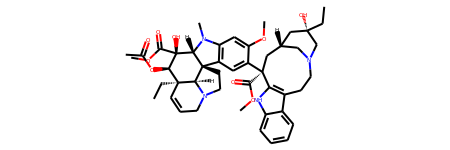

In [116]:
d2d_ligand = ligands[similarities_d2d[283][0]]
d2d_ligand

Její drugbankové hity.

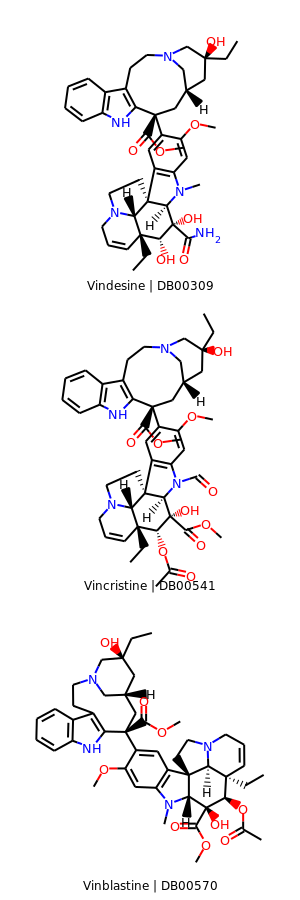

In [117]:
db_hits = [drugbank[i] for i,s in non_empty_similarities_d2d[283][1]]
Draw.MolsToGridImage(db_hits, molsPerRow=1, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in db_hits])

Všechny tyto látky se používají při léčbě rakoviny - primárně cílí na tubulin - zastavuje buněčné dělení v metafázi. Patří mezi vinca alkaloidy - alkaloidy z barvínkovce růžového. Jelikož necílí na d2d recptor tak předpokládám, že jejich ki bylo naměřeno kvůli vedlejším účinkům.

Zpátky k duplikátům. Ze začátku jsem si říkala, že jsem třeba udělala chybu při stahování z databáze. To jsem prozkoumala a chybu jsem nenašla. Nakonec mne napadlo se podívat přímo do dat a zjistila jsem, že je tam molekula doopravdy vícekrát, jen má každý záznam jiné hodnoty veličin vyjadřující aktivitu. Jen nevím, proč tam jsou vícekrát? Tak jsem se rozhodla provést vše znovu a trochu rychleji, ale na datasetu s unikatními molekulami - porovnávala jsem je pomocí smilesů.

In [118]:
ligands_no_duplicates_smiles = []
for l in ligands:
    if Chem.MolToSmiles(l) in ligands_no_duplicates_smiles:
        continue
    ligands_no_duplicates_smiles.append(Chem.MolToSmiles(l))
len(ligands_no_duplicates_smiles)

7962

Dataset se mi rázem hodně zmenšil.

In [119]:
ligands_no_duplicates = [Chem.MolFromSmiles(l) for l in ligands_no_duplicates_smiles]
d2d_hfp_new = [Chem.GetMorganFingerprintAsBitVect(l, 2, nBits = 1024) for l in ligands_no_duplicates]
d2d_hits = []
for i, l in enumerate(d2d_hfp_new):
    s = similarity_search(l, db_hfp, 0.8)
    if s:
        d2d_hits.append((i,s))
drugs_hitcount = {}
for l, h in d2d_hits:
    for x, s in h:
        drugs_hitcount[x] = drugs_hitcount.get(x, 0) + 1
drugs_hitcount_sorted = diff_keys_sorted = {k: v for k,v in sorted(drugs_hitcount.items(), key=lambda x:x[1], reverse = True)}
drugs_hitcount_sorted

{1113: 5,
 90: 4,
 579: 4,
 389: 3,
 1012: 3,
 919: 3,
 4340: 3,
 4534: 3,
 279: 3,
 455: 3,
 928: 3,
 6927: 3,
 330: 3,
 505: 3,
 1109: 3,
 332: 3,
 876: 3,
 456: 3,
 2939: 3,
 252: 2,
 867: 2,
 295: 2,
 598: 2,
 302: 2,
 937: 2,
 1076: 2,
 231: 2,
 830: 2,
 840: 2,
 408: 2,
 639: 2,
 861: 2,
 135: 2,
 1066: 2,
 1411: 2,
 278: 2,
 1212: 2,
 1087: 2,
 210: 2,
 453: 2,
 4310: 2,
 1013: 2,
 1041: 2,
 2678: 2,
 320: 2,
 732: 2,
 186: 2,
 187: 2,
 881: 2,
 566: 2,
 359: 2,
 6300: 2,
 6369: 2,
 683: 2,
 1663: 2,
 3547: 2,
 199: 2,
 426: 2,
 888: 2,
 6928: 2,
 364: 2,
 508: 2,
 714: 2,
 476: 2,
 925: 2,
 98: 2,
 3497: 2,
 218: 2,
 923: 2,
 1077: 2,
 242: 2,
 1128: 2,
 1518: 2,
 289: 2,
 991: 2,
 1053: 2,
 300: 1,
 321: 1,
 4444: 1,
 223: 1,
 136: 1,
 1004: 1,
 2587: 1,
 4626: 1,
 164: 1,
 952: 1,
 1112: 1,
 158: 1,
 1027: 1,
 459: 1,
 1067: 1,
 2519: 1,
 377: 1,
 1018: 1,
 1100: 1,
 246: 1,
 288: 1,
 1093: 1,
 681: 1,
 375: 1,
 4148: 1,
 743: 1,
 1052: 1,
 6638: 1,
 386: 1,
 4355: 1,
 814: 1

I tady se čísla bez duplikátů zmenšila. Stejně je hitů tolik, že je nad mé síly je všechny projít.

Následuje diversity picking, ten jsem dělala nejdříve.

In [120]:
def distance_function(m1, m2):#, data = d2d_hfp
    return 1 - DataStructs.TanimotoSimilarity(d2d_hfp[m1], d2d_hfp[m2])
    

In [121]:
picker = MaxMinPicker()
diverse_set = list(picker.LazyPick(distance_function, len(ligands), 104))

Mám obří dataset, hledala jsem jedno procento struktur - 104. MolsToGrid molekuly podivně škáloval (byly ultramalinkaté). V takovém množství molekul nedokážu moc dobře odpovědět na otázku, zda-li jsou struktury odlišné, žadná podobnosti jsem si nevšimla. Trochu si myslím, že dopaminový receptor bude profláknutý a ki se na něm měří pro spoustu látek, proto je dataset plný různých molekul, kterým bylo ki změřeno z různých důvodů. Objev jen několika motivů bych čekala u datasetů, které už nebudou tak obecné.

2076


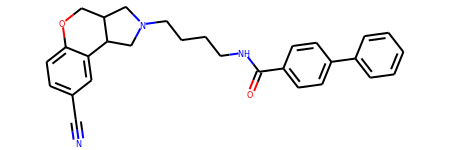

274


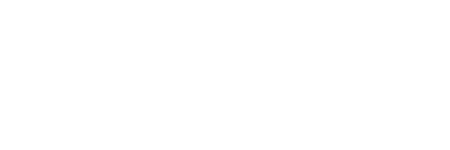

972


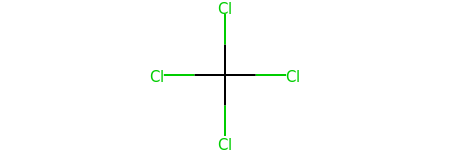

2145


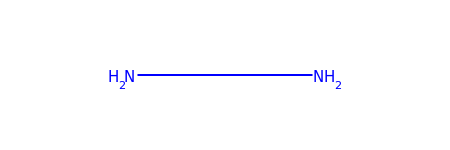

7620


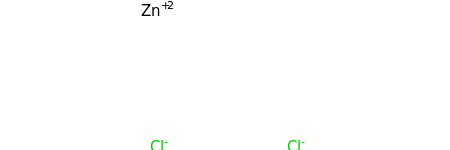

7355


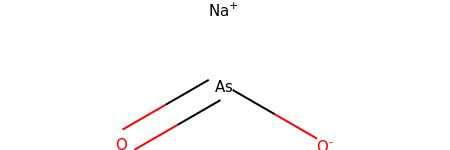

6259


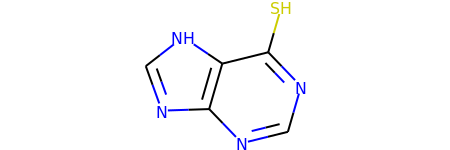

2471


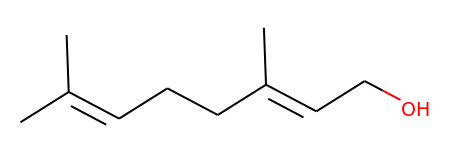

6617


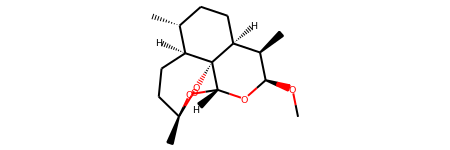

2797


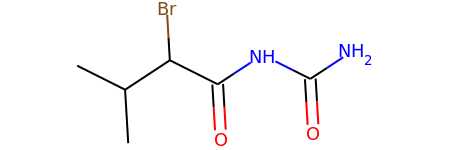

3844


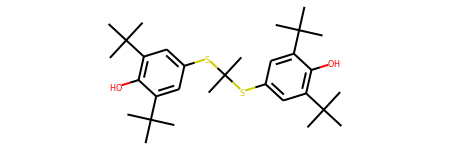

4571


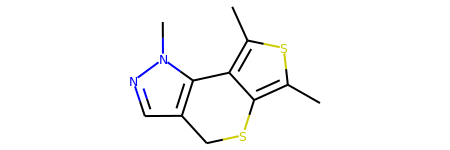

3372


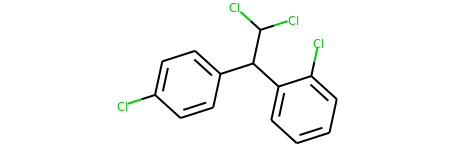

5111


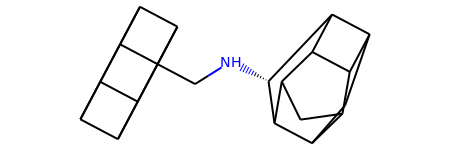

4298


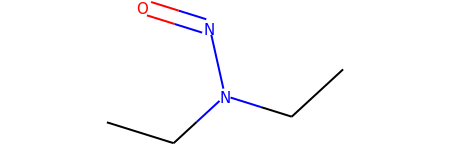

8691


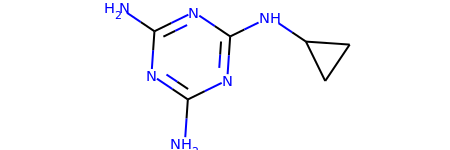

7433


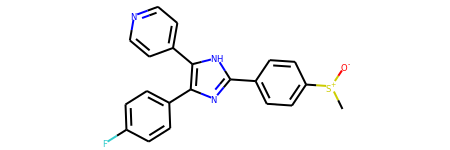

476


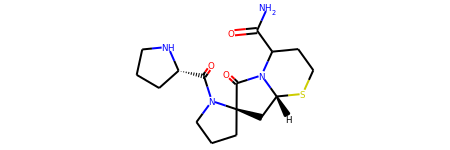

1064


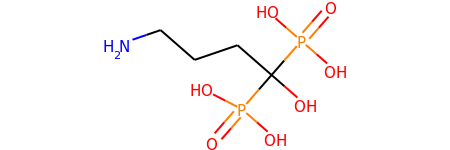

7158


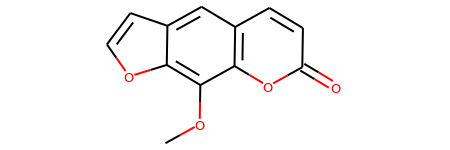

9263


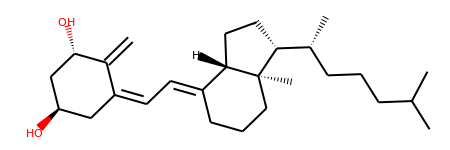

7705


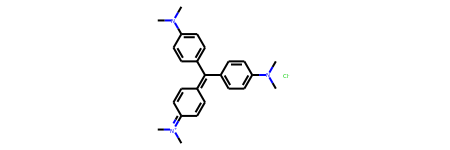

2615


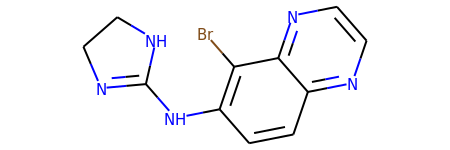

2386


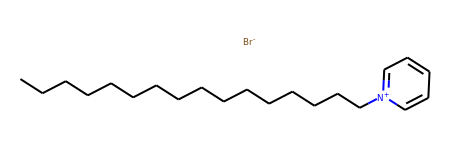

3944


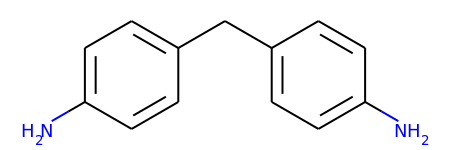

4821


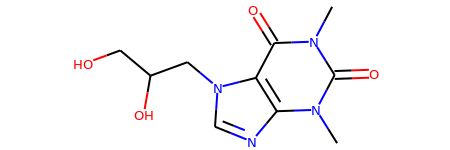

7601


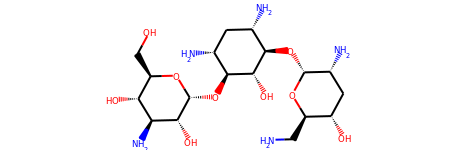

366


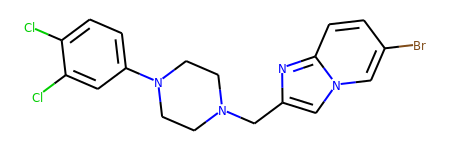

931


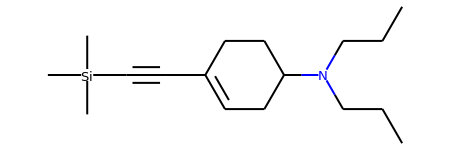

8605


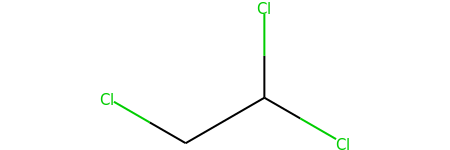

5418


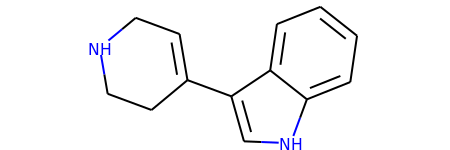

3876


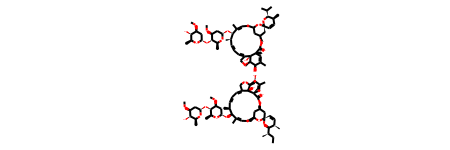

7565


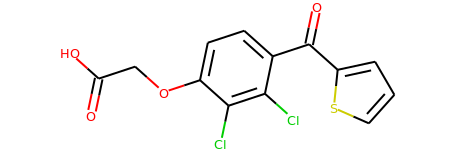

8287


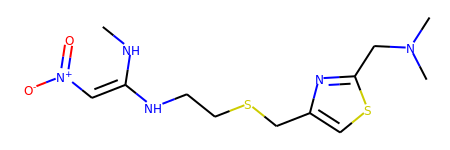

3757


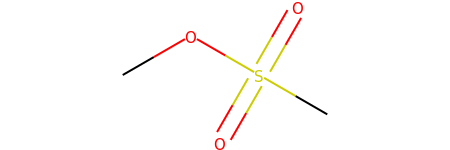

4758


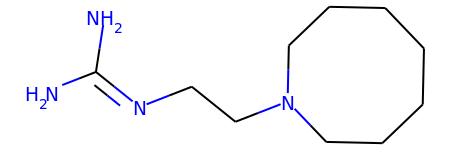

2287


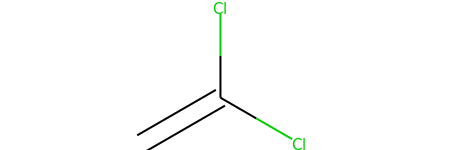

5916


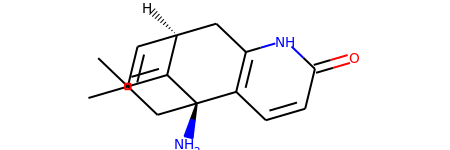

8777


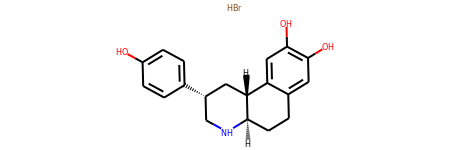

6332


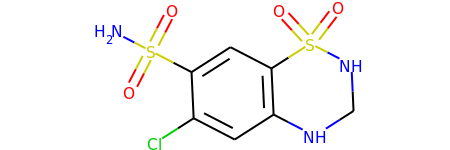

1470


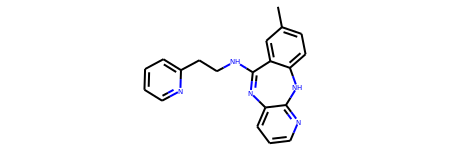

4246


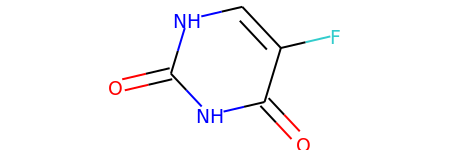

2614


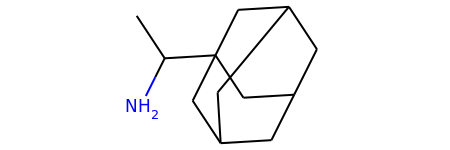

9660


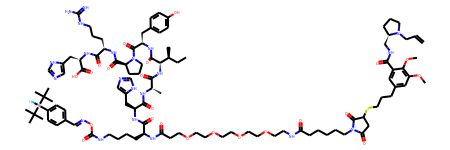

3893


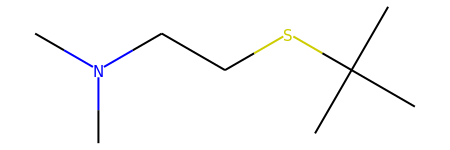

7418


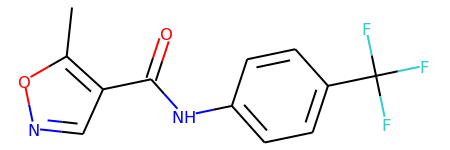

17


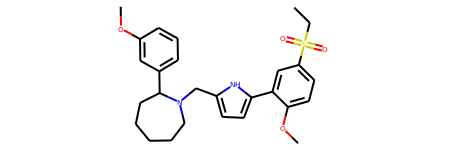

6618


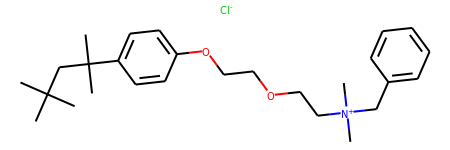

2165


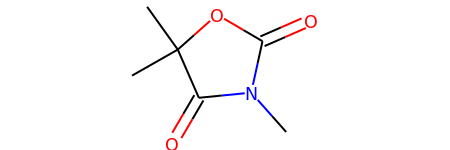

3969


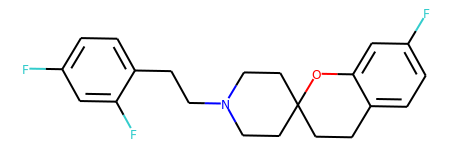

4471


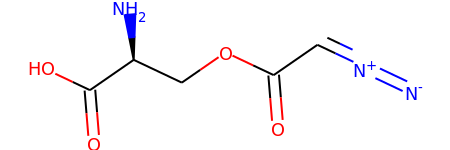

5779


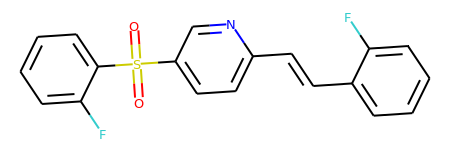

1034


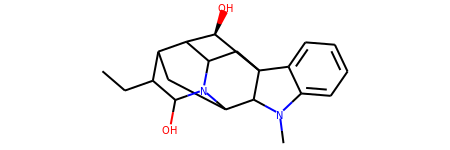

1979


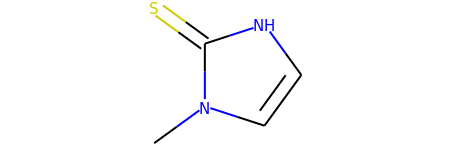

3870


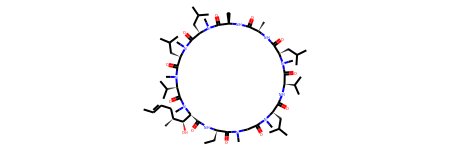

5752


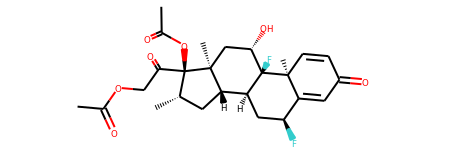

7719


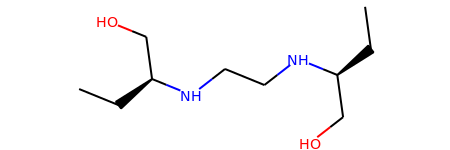

8332


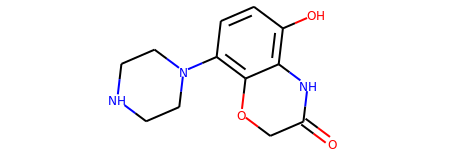

599


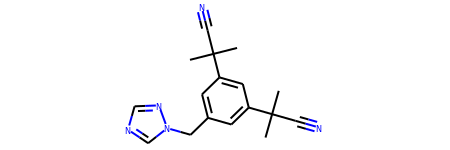

271


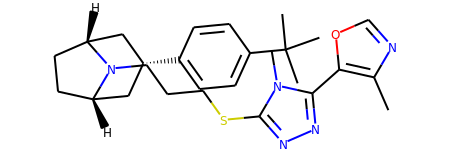

622


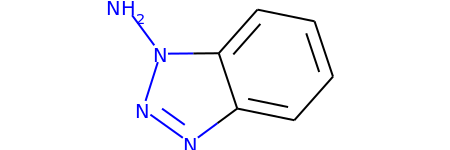

4722


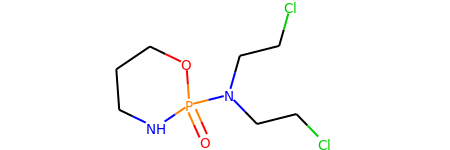

8614


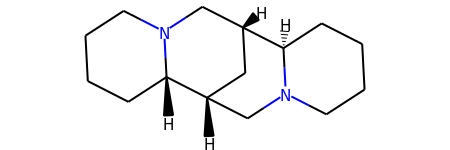

1104


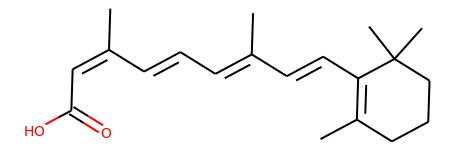

7034


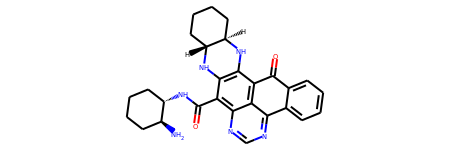

8226


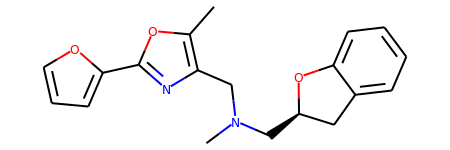

1795


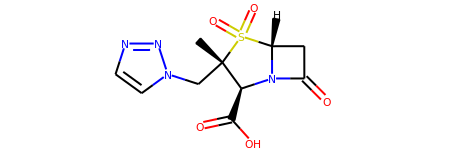

1905


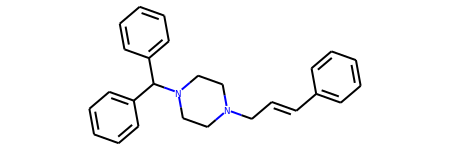

2780


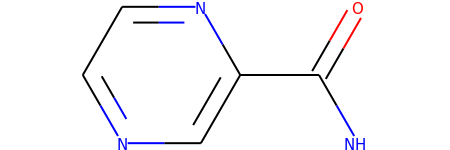

1796


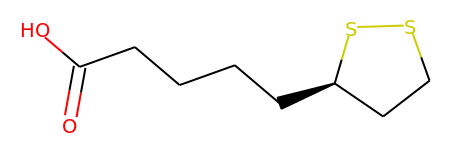

7625


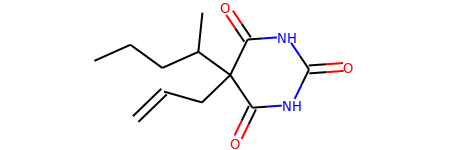

7328


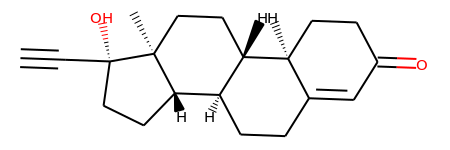

293


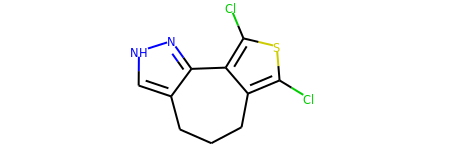

7470


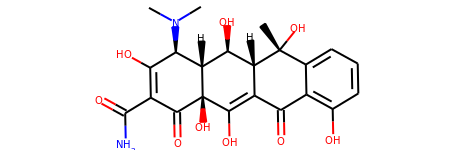

7764


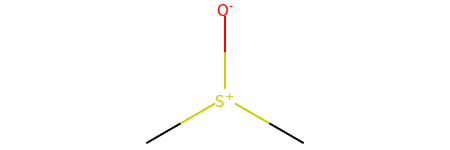

7760


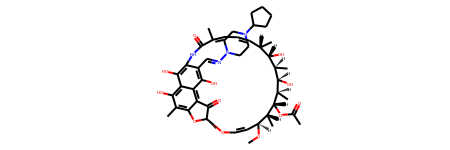

6249


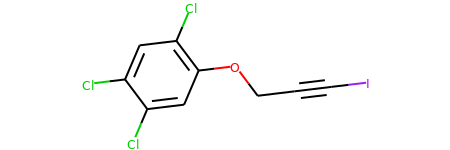

4304


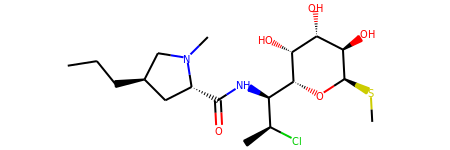

1997


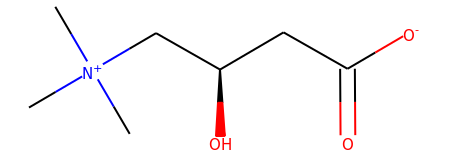

4735


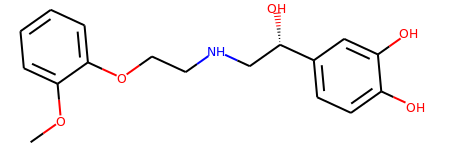

609


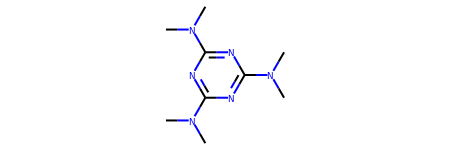

4907


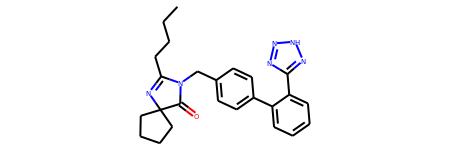

7708


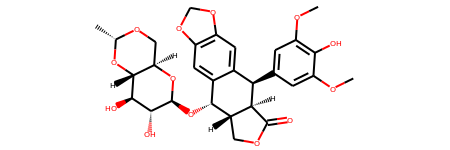

2363


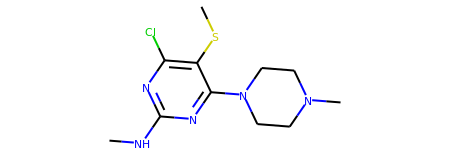

465


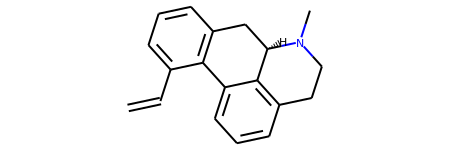

7852


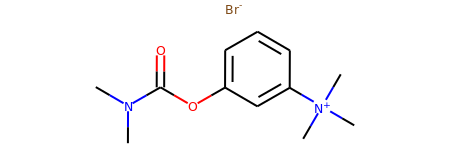

2432


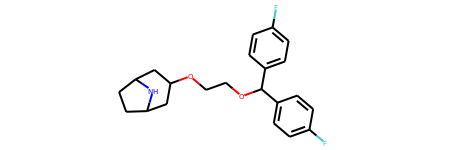

9979


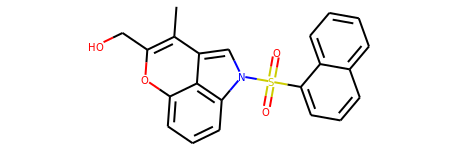

8321


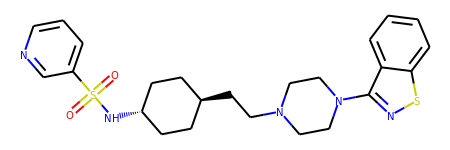

273


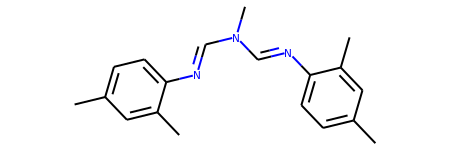

2641


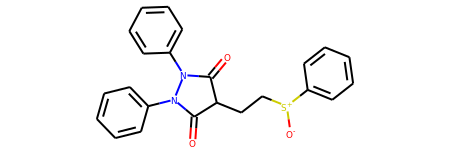

7202


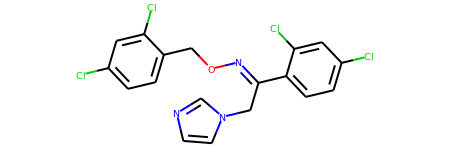

3222


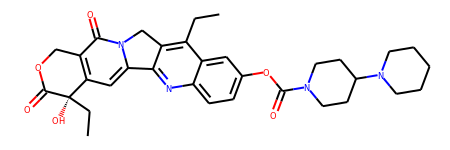

4908


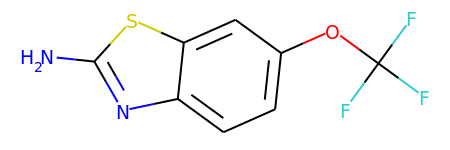

4505


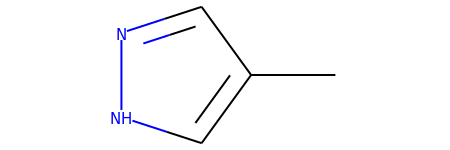

6478


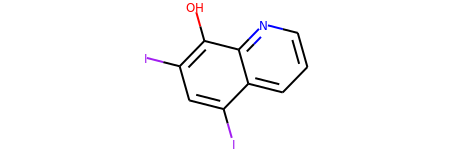

8072


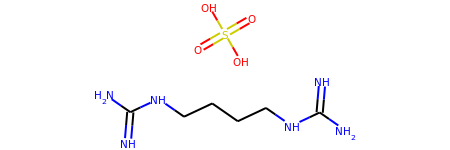

5448


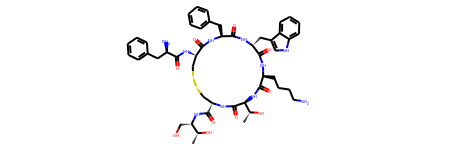

2627


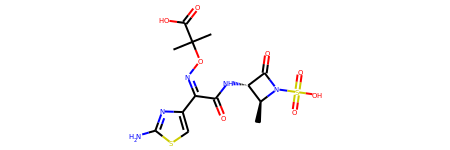

191


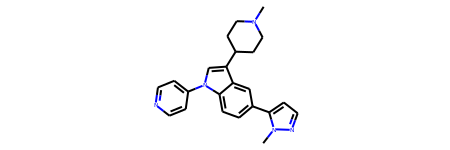

7724


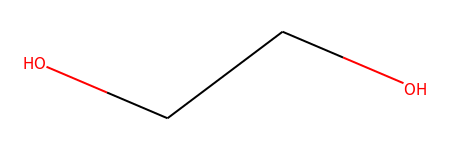

8832


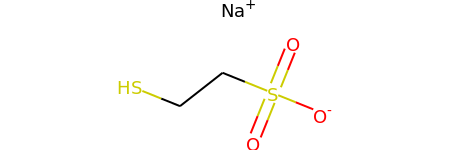

6769


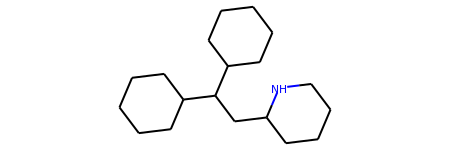

7756


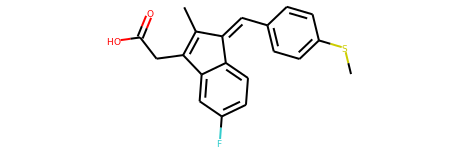

In [122]:
for mol in diverse_set:
    print(mol)
    display(ligands[mol])

Můj dataset mě nepřestává udivovat, mám dokonce molekulu bez atomů... Po pohledu do dat to taková záhada zase není, prostě v té tabulce chybí smiles, ze kterých tady stavím molekuly... Je to chlorid chromitý. 

In [123]:
invis = Chem.AddHs(ligands[274]) #? vodík
Chem.MolToSmiles(invis)

''